**A Basic CNN Model**

In [1]:
#Definitions -
#1. Spatial Dimension - The width and height of an image
#2. Feature map - It is the output of a convolutional layer that highlights specific patterns or features detected by a filter in an input image or feature map
#3. Robust - being able to handle challenges or variations effectively without failing
#4. Softmax - mathematical function that converts a vector of raw scores (logits) into a probability distribution, where the sum of all probabilities equals 1
#5. Weights - Values in a neural network that determine how much influence each input has on the output; they are assigned and adjusted by the model during training through a process called backpropagation
#6. Gradient - value that tells the model how much to change its weights to improve the prediction and reduce the error


import torch     #used while applying deep learning
import torch.nn as nn     #Imports PyTorch's neural network module, which includes classes for building and training neural networks.
import torch.optim as optim     #implementing optimization algorithms like SGD and Adam
from torchvision import datasets, transforms     #for preprocessing
from torch.utils.data import DataLoader      # load datasets in batches for training and testing
import matplotlib.pyplot as plt      # interactive and animated visualizations
import seaborn as sns       # informative statistical graphics
from sklearn.metrics import confusion_matrix       #used for classification model evaluation
import numpy as np      #used for numerical computations

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')      #uses GPU if available; otherwise, it defaults to the CPU

# Data preprocessing
transform = transforms.Compose([     #transforms.Compose() combines several image changes into one step, so all the changes happen one after another to each image.
    transforms.RandomHorizontalFlip(),    #Randomly flips the image horizontally with a 50% probability - [  transforms.RandomHorizontalFlip(p=0.5)  ]
    transforms.RandomCrop(32, padding=4),      #creates variations of the original image  -  []
    transforms.ToTensor(),        #converts PIL Image or a NumPy array into a PyTorch tensor ie. changes pixel values from the range [0, 255] to [0, 1] by dividing by 255
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))      #subtracting every image pixel with 0.5(to make the mean centre around 0) and then dividing it with 0.5 (to make standard deviation equal to 1)
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)     # root is location where dataset has to be downloaded(from internet) if its not already present. And then
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)     #random hori flipping, cropping is applied to images. Train = true - loads training dataset, Train = false - loads test dataset

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)     #Randomly shuffles the data at the beginning of each epoch to ensure that the model doesn't learn patterns based on the order of the training data
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)      #test data - not shuffled so that the model is evaluated in the same order each time, which helps to get consistent and comparable results

#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2) - this is format, num_workers = 0 - data is loaded in the main process, one batch at a time
#when num_workers = 2/more - DataLoader uses 2 separate subprocesses to load and process data at the same time.


# Define the CNN model
class CNNModel(nn.Module):    #nn.Module is the base class(already exists in Pytorch) for all neural networks, CNN module is its subclass that inherits all its properties and modules
    def __init__(self):
        super(CNNModel, self).__init__()   #makes sure that the CNNModel class is properly set up as a PyTorch model by initializing the base nn.Module class
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  #ip = 32x32x3    op = 32x32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)   #ip = 32x32x32  op = 32x32x64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)   #ip = 32x32x64  op = 32x32x128

#Output widtha nd height formula= (Input img size - kernel size +2p)/striding + 1
#Doubling (e.g., 32 → 64 → 128 → 256) is commonly used because it simplifies the network design and aligns with the binary nature of computer hardware (e.g., powers of 2 are efficient for memory allocation and computation).

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces size by half

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 256)  #creates a fully connected (dense)layer that takes an input with a size of 128 * 8 * 8 (the flattened output of the previous convolutional layers) and maps it to an output of size 256
        self.fc2 = nn.Linear(256, 10)  #takes the 256-sized input from the previous layer and maps it to an output of size 10

        # Activation and Dropout
        self.relu = nn.ReLU()    #Introduces non-linearity by making all -ve values = 0, +ve values = unchanged, helps model in learning complex patterns
        self.dropout = nn.Dropout(0.5) #Drops/ deactivate 50% of neurons (a random subset of neurons) from the specified layer(s) is set to zero, this is to prevent overfitting (ie so that model doesn't rely too heavily on specific neurons)

    def forward(self, x):    #it tells how input data passes through the network layers to produce an output
        x = self.relu(self.conv1(x))   # passes x through the first convolutional layer (conv1) and applies the ReLU
        x = self.pool(self.relu(self.conv2(x)))    #Passes the output of the second convolutional layer through a ReLU, then applies max-pooling to reduce the spatial dimensions
        x = self.pool(self.relu(self.conv3(x)))     #Same as above

        # Flattening
        x = x.view(x.size(0), -1)    #view is used to reshape a tensor without changing its data   x.size(0) = Batch size, -1 automatically calculates size of the remaining dimensions
        x = self.dropout(self.relu(self.fc1(x)))   #1st goes thru fully connected layer, then relu is applied, then dropout
        x = self.fc2(x)     #This is passed thru 2nd fully connected layer
        return x    #finally return x
'''
x.size(0) is 64 (batch size),
x.size(1) is 3 (number of channels),
x.size(2) is 32 (height of the image),
x.size(3) is 32 (width of the image).


      Expression               x.size(0)       x.size(1)       x.size(2)       x.size(3)       New Shape
x = x.view(x.size(0), -1)       64              3               32            32          (64, 3072)
x = x.view(x.size(1), -1)       64              3               32            32          (3, 65536)
x = x.view(x.size(2), -1)       64              3               32            32          (32, 6144)
x = x.view(x.size(3), -1)       64              3               32            32          (32, 6144)



'''

# Instantiate the model, loss function, and optimizer
model = CNNModel().to(device)   # Creating an instance of the CNNModel class and moves it to the specified device (CPU or GPU) for computation
criterion = nn.CrossEntropyLoss()     #CrossEntropyLoss is a measure of the difference between two probability distributions — the predicted probabilities (from the model) and the true class labels (thr ground truth) - lesser the better
optimizer = optim.Adam(model.parameters(), lr=0.001)     #lr value can vary from 0.00001 to 0.1, best is 0.001
# model.parameters() [it is a method provided by the nn.Module class] - returns all the parameters from layers like conv1, conv2, conv3, and the fully connected layers fc1 and fc2 in your CNNModel


# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0      #for tracking cumulative loss of current epoch
    correct = 0       #for tracking no. of correct predictions of current epoch
    total = 0       #Initializes a counter for the total number of samples processed

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)   # Moves ip an dlabels to specified device (CPU or GPU)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()     #This clears any previously calculated gradients, so they don't add up and interfere with the current training step
        loss.backward()
        optimizer.step()

        # Calculate statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
#model has predicted three probabilities for three classes: Class 0 has a probability of 0.1, Class 1 has 0.3, and Class 2 has 0.6. The highest probability is 0.6, which corresponds to Class 2
#This tells you that the model has predicted Class 2 as the most likely class for the input. The _ is used because we don’t need the value 0.6, just the index (2).

        total += labels.size(0)
        correct += (predicted == labels).sum().item()    #Item is used as it converts 'sum' into a regular Python type (int or float), making it more compatible with standard Python operations

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")   #.2f = 2 decimal places


# Testing loop
model.eval()  # Set model to evaluation mode - ie turns off dropout and batch normalization for good predictions
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():      #diables gradient calc during tesing process
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())   # Moves the true labels to the CPU, converts them to a NumPy array, and adds them to the all_labels
        all_preds.extend(predicted.cpu().numpy())   # Moves the predicted labels to the CPU, converts them to a NumPy array, and adds them to the all_preds list

print(f"Test Accuracy: {100 * correct / total:.2f}%")

100%|██████████| 170M/170M [00:02<00:00, 62.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/5, Loss: 1.6261, Accuracy: 40.11%
Epoch 2/5, Loss: 1.2265, Accuracy: 55.97%
Epoch 3/5, Loss: 1.0592, Accuracy: 62.53%
Epoch 4/5, Loss: 0.9612, Accuracy: 66.25%
Epoch 5/5, Loss: 0.9139, Accuracy: 68.17%
Test Accuracy: 71.59%


**Confusion Matrix**

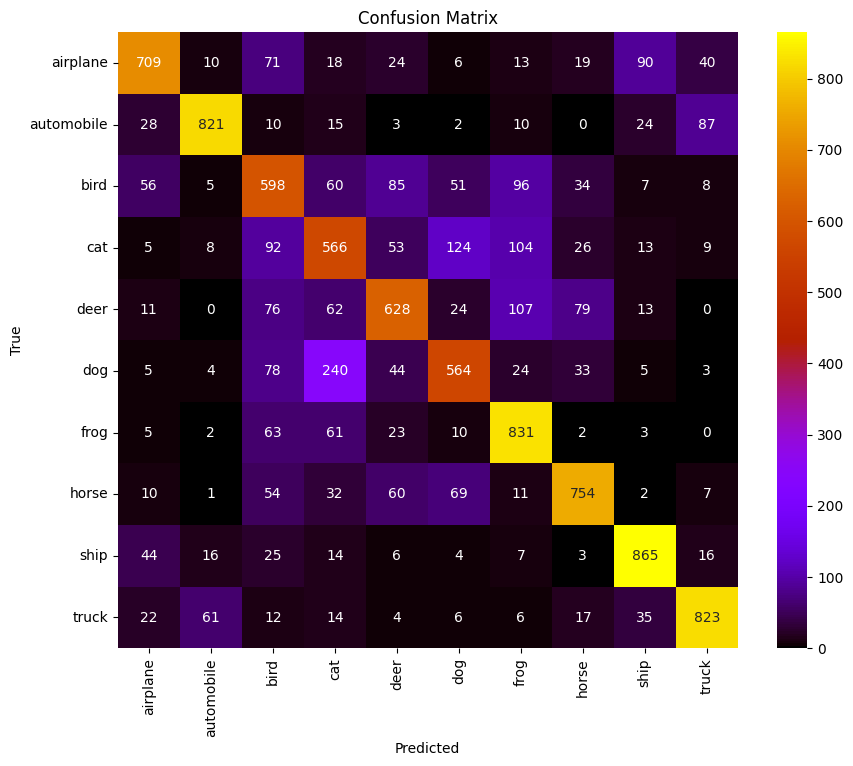

'\nSequential Colormaps\nUsed for data that progresses from low to high:\n\nPerceptually Uniform:\nviridis, plasma, cividis, inferno, magma, twilight, turbo\n\nSingle Hue:\nBlues, Greens, Reds, Oranges, Purples, Greys\n\nMulti-Hue:\ncool, hot, spring, summer, autumn, winter, Wistia\n\nDiverging Colormaps\nUsed for data that has a meaningful midpoint (e.g., zero):\ncoolwarm, bwr, seismic, Spectral, RdYlBu, RdYlGn, PiYG, PRGn, BrBG, RdBu, RdGy, PuOr\n\nCyclic Colormaps\nUsed for data that wraps around cyclically (e.g., angles):\ntwilight, twilight_shifted, hsv\n\nQualitative Colormaps\nUsed for categorical data:\nAccent, Dark2, Paired, Pastel1, Pastel2, Set1, Set2, Set3, tab10, tab20, tab20b, tab20c\n\nMiscellaneous Colormaps\nflag, prism, ocean, cubehelix, rainbow, terrain, gnuplot, gnuplot2, CMRmap\n'

In [2]:
# Confusion matrix visualization
cm = confusion_matrix(all_labels, all_preds)    #true values ad predicted values
plt.figure(figsize=(10, 8))     #plots a figure with 10x8 inches dimensions
sns.heatmap(cm, annot=True, fmt='d', cmap='gnuplot', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)     #annot = True tells that we want numerical values in each box
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()




#String Format Codes
'''
d: Decimal integers (e.g., 5, -3).
e: Scientific notation with a lowercase "e" (e.g., 1.23e+02).
E: Scientific notation with an uppercase "E" (e.g., 1.23E+02).
f: Fixed-point decimal notation (e.g., 123.45).
g: General format (e.g., uses e for large/small values and f otherwise).
G: General format (same as g but uses E for scientific notation).
o: Octal integers (e.g., 12 in octal is 14).
x: Hexadecimal integers with lowercase letters (e.g., 0x1a).
X: Hexadecimal integers with uppercase letters (e.g., 0x1A).
c: Single character (e.g., A).
s: String (e.g., 'text').
%: Percentage (e.g., 12.34%).
Custom Formats
You can also use custom formats by defining a specific format string. For example:

".2f": Fixed-point decimal with 2 digits after the decimal point (e.g., 12.34).
"0.2%": Percentage with 2 decimal places (e.g., 12.34%).
'''

#Color maps
'''
Sequential Colormaps
Used for data that progresses from low to high:

Perceptually Uniform:
viridis, plasma, cividis, inferno, magma, twilight, turbo

Single Hue:
Blues, Greens, Reds, Oranges, Purples, Greys

Multi-Hue:
cool, hot, spring, summer, autumn, winter, Wistia

Diverging Colormaps
Used for data that has a meaningful midpoint (e.g., zero):
coolwarm, bwr, seismic, Spectral, RdYlBu, RdYlGn, PiYG, PRGn, BrBG, RdBu, RdGy, PuOr

Cyclic Colormaps
Used for data that wraps around cyclically (e.g., angles):
twilight, twilight_shifted, hsv

Qualitative Colormaps
Used for categorical data:
Accent, Dark2, Paired, Pastel1, Pastel2, Set1, Set2, Set3, tab10, tab20, tab20b, tab20c

Miscellaneous Colormaps
flag, prism, ocean, cubehelix, rainbow, terrain, gnuplot, gnuplot2, CMRmap
'''


**Generating an image from Dataset with a predefined index**

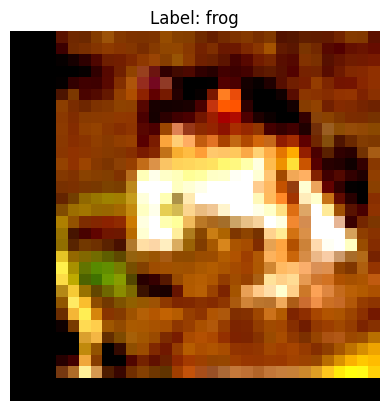

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Get one image from the training dataset
image, label = train_dataset[0]  # Replace 0 with any index to access different images

# Convert the image from a PyTorch tensor to a NumPy array for visualization
image_np = image.permute(1, 2, 0).numpy()  # Reorder dimensions to (height, width, channels)

# Display the image
plt.imshow((image_np + 0.5).clip(0, 1))  # Undo the normalization (assuming it was normalized with mean=0.5, std=0.5)
plt.title(f'Label: {train_dataset.classes[label]}')  # Display the label of the image
plt.axis('off')  # Hide the axis
plt.show()


**Generating an image randomly**

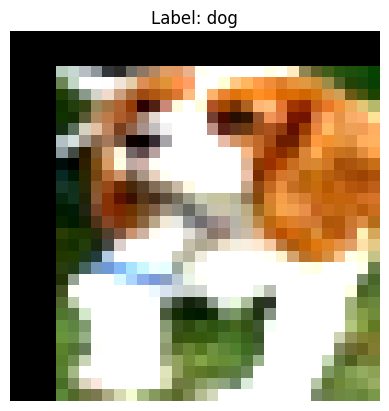

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Choose a random index from the dataset
random_index = random.randint(0, len(train_dataset) - 1)

# Get the image and label at the random index
image, label = train_dataset[random_index]

# Convert the image from a PyTorch tensor to a NumPy array for visualization
image_np = image.permute(1, 2, 0).numpy()

# Display the image
plt.imshow((image_np + 0.5).clip(0, 1))  # Undo the normalization (if applied)
plt.title(f'Label: {train_dataset.classes[label]}')  # Display the label of the image
plt.axis('off')  # Hide the axis
plt.show()

**Classification Report without using SKLEARN**

In [5]:
# Initialize variables
class_totals = np.zeros(len(train_dataset.classes))  # Total occurrences of each class
class_correct = np.zeros(len(train_dataset.classes))  # Correct predictions for each class
class_predictions = np.zeros(len(train_dataset.classes))  # Predictions for each class

# Calculate class-wise metrics
for true, pred in zip(all_labels, all_preds):
    class_totals[true] += 1
    class_predictions[pred] += 1
    if true == pred:
        class_correct[true] += 1

# Accuracy, Precision, Recall, F1 Score calculation
class_accuracy = class_correct / class_totals
class_precision = class_correct / class_predictions
class_recall = class_correct / class_totals
class_f1_score = 2 * (class_precision * class_recall) / (class_precision + class_recall)

# Handle divisions by zero for precision and F1 scores
class_precision = np.nan_to_num(class_precision)
class_f1_score = np.nan_to_num(class_f1_score)

# Print results for each class
print("Class-wise Metrics:\n")
for idx, class_name in enumerate(train_dataset.classes):
    print(f"Class: {class_name}")
    print(f"  Accuracy: {class_accuracy[idx]:.4f}")
    print(f"  Precision: {class_precision[idx]:.4f}")
    print(f"  Recall: {class_recall[idx]:.4f}")
    print(f"  F1 Score: {class_f1_score[idx]:.4f}\n")


Class-wise Metrics:

Class: airplane
  Accuracy: 0.7090
  Precision: 0.7922
  Recall: 0.7090
  F1 Score: 0.7483

Class: automobile
  Accuracy: 0.8210
  Precision: 0.8847
  Recall: 0.8210
  F1 Score: 0.8517

Class: bird
  Accuracy: 0.5980
  Precision: 0.5542
  Recall: 0.5980
  F1 Score: 0.5753

Class: cat
  Accuracy: 0.5660
  Precision: 0.5231
  Recall: 0.5660
  F1 Score: 0.5437

Class: deer
  Accuracy: 0.6280
  Precision: 0.6753
  Recall: 0.6280
  F1 Score: 0.6508

Class: dog
  Accuracy: 0.5640
  Precision: 0.6558
  Recall: 0.5640
  F1 Score: 0.6065

Class: frog
  Accuracy: 0.8310
  Precision: 0.6873
  Recall: 0.8310
  F1 Score: 0.7524

Class: horse
  Accuracy: 0.7540
  Precision: 0.7797
  Recall: 0.7540
  F1 Score: 0.7666

Class: ship
  Accuracy: 0.8650
  Precision: 0.8184
  Recall: 0.8650
  F1 Score: 0.8410

Class: truck
  Accuracy: 0.8230
  Precision: 0.8288
  Recall: 0.8230
  F1 Score: 0.8259



**Classification Report using SKLEARN**

In [6]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes, digits=4)

# Print the classification report
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

    airplane     0.7922    0.7090    0.7483      1000
  automobile     0.8847    0.8210    0.8517      1000
        bird     0.5542    0.5980    0.5753      1000
         cat     0.5231    0.5660    0.5437      1000
        deer     0.6753    0.6280    0.6508      1000
         dog     0.6558    0.5640    0.6065      1000
        frog     0.6873    0.8310    0.7524      1000
       horse     0.7797    0.7540    0.7666      1000
        ship     0.8184    0.8650    0.8410      1000
       truck     0.8288    0.8230    0.8259      1000

    accuracy                         0.7159     10000
   macro avg     0.7200    0.7159    0.7162     10000
weighted avg     0.7200    0.7159    0.7162     10000



**Class for a basic LeNet model**

In [7]:
import torch
import torch.nn as nn

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        # Convolutional Layer 1: Input 1x32x32 -> Output 6x28x28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)

        # Average Pooling Layer 1: Input 6x28x28 -> Output 6x14x14
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Convolutional Layer 2: Input 6x14x14 -> Output 16x10x10
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)

        # Average Pooling Layer 2: Input 16x10x10 -> Output 16x5x5
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Convolutional Layer 3 (Fully Connected Convolution): Input 16x5x5 -> Output 120x1x1
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)

        # Fully Connected Layer 1: Input 120 -> Output 84
        self.fc1 = nn.Linear(in_features=120, out_features=84)

        # Fully Connected Layer 2 (Output Layer): Input 84 -> Output 10
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        # Pass through each layer
        x = torch.tanh(self.conv1(x))
        x = self.pool1(x)
        x = torch.tanh(self.conv2(x))
        x = self.pool2(x)
        x = torch.tanh(self.conv3(x))

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 120)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)  # No activation function since it's a classification layer with SoftMax during loss
        return x

# Instantiate the model
lenet5 = LeNet5()
print(lenet5)


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
